In [11]:
from custom_models.mlp import MLP
from helper_methods import get_data_loaders
from pipeline import CustomModelPipeline
from torch import optim
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats
import torch


# set seaborn style
sns.set_theme(
    context="notebook", style="whitegrid", palette="bright", color_codes=True, rc=None
)

In [12]:
# Fixed parameters
N_REPEATS = 5
N_EPOCHS = 100
LR = 0.01
ES_PATIENCE = 15

# 1. Hidden Layer Sizes - Experiment 1
HIDDEN_LAYERS_1 = (256, 64)
HIDDEN_LAYERS_3 = (1024, 256)
HIDDEN_LAYERS_5 = (4096, 1024)

# 2. Hidden Layer Depth - Experiment 2
# From previous exp. we take layer sizes of (1024, 256) 
HIDDEN_LAYERS_X1 = (1024,)
HIDDEN_LAYERS_X3 = (1024, 512, 256)




HIDDEN_LAYERS_CONFIG = HIDDEN_LAYERS_3

In [13]:
def get_class_weights(train_loader, n_classes):
    """Calculate class weights for imbalanced dataset"""
    # Get the number of samples in each class
    class_counts = np.zeros(n_classes)
    for _, labels in train_loader:
        for label in labels:
            class_counts[label.item()] += 1

    # Calculate the weights
    total_samples = sum(class_counts)
    class_weights = total_samples / (n_classes * class_counts)

    # Ensure weights tensor has correct shape and is of expected type
    return torch.tensor(class_weights, dtype=torch.float).to(
        "cuda" if torch.cuda.is_available() else "cpu"
    )


def init_pipeline(
    train_loader,
    validation_loader,
    train_loader_at_eval,
    test_loader,
    input_size,
    num_classes,
    patience=ES_PATIENCE,  # Add patience parameter
):
    """Initialize pipeline with MLP model"""
    # Initialize MLP with proper parameters
    model = MLP(
        input_size=input_size,
        hidden_sizes=HIDDEN_LAYERS_CONFIG,
        num_classes=num_classes,
    )

    pipeline = CustomModelPipeline(
        model=model,
        criterion=nn.CrossEntropyLoss(),
        min_delta=0.001,
        optimizer_class=optim.RMSprop,
        optimizer_params={
            "lr": LR,
        },
        n_epochs=N_EPOCHS,
        training_data=train_loader,
        validation_data=validation_loader,
        test_data=test_loader,
        patience=patience,  # Pass patience parameter
        device="cuda" if torch.cuda.is_available() else "cpu",
    )
    return pipeline


(
    train_loader,
    train_loader_at_eval,
    test_loader,
    validation_loader,
    n_channels,
    n_classes,
    task,
    pil_dataset,
) = get_data_loaders()

# first sample
sample = next(iter(train_loader))
print(f"Sample Shape: {sample[0].shape}")

# No of Neurons in Input Layer
# Output is flattened before feeding to MLP
input_size = n_channels * sample[0].shape[2] * sample[0].shape[3]

# No of Neurons in Output Layer
num_classes = n_classes

print(f"Input size: {input_size}, Number of classes: {num_classes}")

accuracies = []
f1_scores = []
t_losses = []
v_losses = []
t_durations = []

# Create and execute pipelines for each repeat
for i in range(N_REPEATS):
    print(f"Repeat {i + 1}/{N_REPEATS}")
    pipeline = init_pipeline(
        train_loader,
        validation_loader,
        train_loader_at_eval,
        test_loader,
        input_size,
        num_classes,
    )
    pipeline.execute_and_validate()
    # get scores on test data
    scores = pipeline.get_validation_scores()
    accuracies.append(scores["accuracy"])
    f1_scores.append(scores["f1"])

    losses = pipeline.get_losses()
    t_losses.append(losses["train"])
    v_losses.append(losses["val"])

    t_durations.append(pipeline.get_run_duration())

MedMNIST v3.0.2 @ https://github.com/MedMNIST/MedMNIST/
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Using downloaded and verified file: C:\Users\josem\.medmnist\dermamnist.npz
Sample Shape: torch.Size([128, 3, 28, 28])
Input size: 2352, Number of classes: 7
Repeat 1/5
Using device: cuda
Starting training for 100 epochs...
Epoch 1/100 - Train Loss: 2.3172, Val Loss: 1.1286
Epoch 2/100 - Train Loss: 1.1091, Val Loss: 1.1039
Epoch 3/100 - Train Loss: 1.0618, Val Loss: 1.0755
Epoch 4/100 - Train Loss: 1.0516, Val Loss: 1.0145
Epoch 5/100 - Train Loss: 1.0148, Val Loss: 1.0112
Epoch 6/100 - Train Loss: 1.0128, Val Loss: 0.9884
Epoch 7/100 - Train Loss: 0.9972, Val Loss: 0.9822
Epoch 8/100 - Train Loss: 0.9947, Val Loss: 0.9869
Epoch 9/100 - Train Loss: 0.9909, Val Loss: 0.9649
Epoch 10/100 - Train Loss: 0.9848

In [14]:
# From: https://stackoverflow.com/a/15034143
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

mci_accuracy = mean_confidence_interval(accuracies)
mci_f1 = mean_confidence_interval(f1_scores)
mci_training_duration = mean_confidence_interval(t_durations)

# Mean +- CI
print(f"Accuracy: {mci_accuracy[0]:.4f} +- {(mci_accuracy[2] - mci_accuracy[0]):.4f}")
print(f"({mci_accuracy[1]:.4f}, {mci_accuracy[2]:.4f})")
print(f"F1 Score: {mci_f1[0]:.4f} +- {(mci_f1[2] - mci_f1[0]):.4f}")
print(f"({mci_f1[1]:.4f}, {mci_f1[2]:.4f})")
print(f"Training Duration: {mci_training_duration[0]:.4f} +- {(mci_training_duration[2] - mci_training_duration[0]):.4f}")
print(f"({mci_training_duration[1]:.4f}, {mci_training_duration[2]:.4f})")


Accuracy: 0.6931 +- 0.0207
(0.6724, 0.7139)
F1 Score: 0.2149 +- 0.0842
(0.1307, 0.2991)
Training Duration: 282.1688 +- 54.6735
(227.4953, 336.8423)


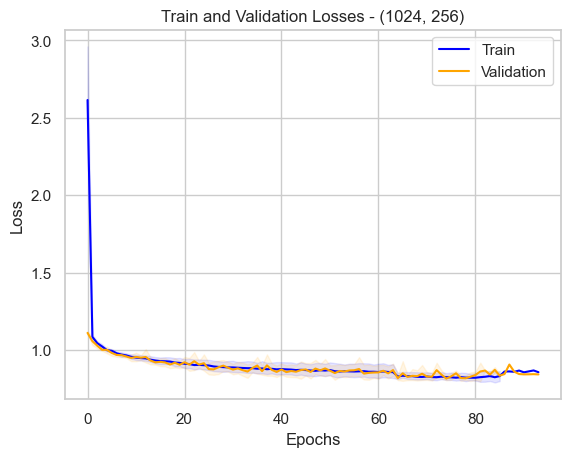

In [15]:
def plot_avg_losses(t_losses, v_losses):
    """Plot average losses with 95% CI, handling early stopping"""
    import pandas as pd
    
    # Find the maximum length across all arrays
    max_length = max(len(losses) for losses in t_losses)
    
    # Create dataframes with named indices to avoid duplicates
    train_df = pd.DataFrame()
    val_df = pd.DataFrame()
    
    # Process each run's data
    for run_idx, (t_loss, v_loss) in enumerate(zip(t_losses, v_losses)):
        # Pad shorter arrays with NaN values
        t_padded = t_loss + [float('nan')] * (max_length - len(t_loss))
        v_padded = v_loss + [float('nan')] * (max_length - len(v_loss))
        
        # Add to dataframes
        train_df[f"run_{run_idx}"] = t_padded
        val_df[f"run_{run_idx}"] = v_padded
    
    # Set epoch as index
    train_df.index = range(max_length)
    val_df.index = range(max_length)
    
    # Create long-form dataframes for seaborn
    train_long = train_df.stack().reset_index()
    train_long.columns = ['epoch', 'run', 'loss']
    train_long['type'] = 'Train'
    
    val_long = val_df.stack().reset_index()
    val_long.columns = ['epoch', 'run', 'loss']
    val_long['type'] = 'Validation'
    
    # Combine data
    combined_df = pd.concat([train_long, val_long])
    
    # Plot with confidence intervals
    ax = sns.lineplot(
        data=combined_df,
        x="epoch",
        y="loss",
        hue="type",
        errorbar=("ci", 95),
        palette={"Train": "blue", "Validation": "orange"}
    )
    
    # Add transparency to the confidence intervals
    for collection in ax.collections:
        collection.set_alpha(0.1)
    
    plt.title(f"Train and Validation Losses - {HIDDEN_LAYERS_CONFIG}")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


plot_avg_losses(t_losses, v_losses)